<a href="https://colab.research.google.com/github/alehb80/skin-lesion-classification/blob/master/skin_lesion_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>SKIN LESION CLASSIFICATION</h1>

* Import API Kaggle

In [0]:
!pip install -q kaggle

In [0]:
!mkdir  ~/.kaggle
!touch ~/.kaggle/kaggle-5.json

api_token = {"username":"gianlucavisentin","key":"c609dca13d58751e6fc9d489a0dddb2d"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 2.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=ee7f909c01357c84270210fc8150a8cbd4eb6ba0cd1819280662521620e0a389
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


* Search the dataser on Kaggle

In [0]:
!kaggle datasets list -s skin

ref                                                    title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
kmader/skin-cancer-mnist-ham10000                      Skin Cancer MNIST: HAM10000                      5GB  2018-09-20 20:36:13          23339        713  0.7058824        
fanconic/skin-cancer-malignant-vs-benign               Skin Cancer: Malignant vs. Benign              325MB  2019-06-19 21:51:11           2970         72  0.75             
nodoubttome/skin-cancer9-classesisic                   Skin Cancer ISIC                                 2GB  2019-08-26 18:59:21            580         14  0.75             
tsaideepak/skin-cancer                                 skin cancer                                    462MB  2019-03-23 19:39:19  

* Download the dataset

In [0]:
# Copy the stackoverflow data set locally.
!kaggle datasets download --force -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [02:37<00:00, 24.3MB/s]
100% 5.20G/5.20G [02:37<00:00, 35.5MB/s]


In [0]:
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10000_images_part_2/ISIC_0029342.jpg  
  inflating: h

* Start with importing libraries

In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc1


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
import keras
from keras.utils.np_utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


* Merge the images in jpg format from both the folders

In [0]:
base_skin_dir = "./"
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [0]:
import os
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(6)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
1482,HAM_0004405,ISIC_0033500,mel,histo,80.0,male,back,./HAM10000_images_part_2/ISIC_0033500.jpg,Melanoma,5
6362,HAM_0001992,ISIC_0025399,nv,follow_up,30.0,female,trunk,./HAM10000_images_part_1/ISIC_0025399.jpg,Melanocytic nevi,4
721,HAM_0004696,ISIC_0026539,bkl,histo,65.0,male,back,./HAM10000_images_part_1/ISIC_0026539.jpg,Benign keratosis-like lesions,2
2365,HAM_0003862,ISIC_0033458,vasc,histo,45.0,male,upper extremity,./HAM10000_images_part_2/ISIC_0033458.jpg,Vascular lesions,6
539,HAM_0003605,ISIC_0026895,bkl,histo,55.0,male,face,./HAM10000_images_part_1/ISIC_0026895.jpg,Benign keratosis-like lesions,2
8731,HAM_0000019,ISIC_0025396,nv,histo,50.0,female,back,./HAM10000_images_part_1/ISIC_0025396.jpg,Melanocytic nevi,4


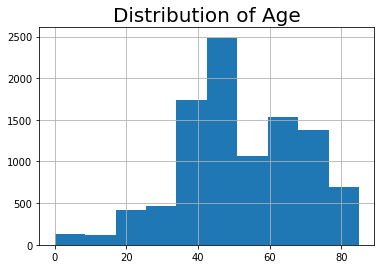

In [0]:
tile_df["age"].hist()
plt.title("Distribution of Age", fontdict={"fontsize" : 20});

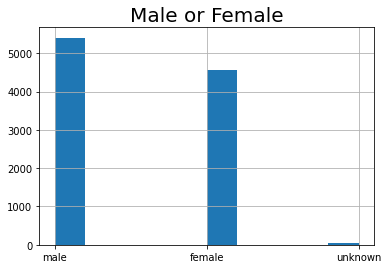

In [0]:
tile_df["sex"].hist()
plt.title("Male or Female", fontdict={"fontsize" : 20});

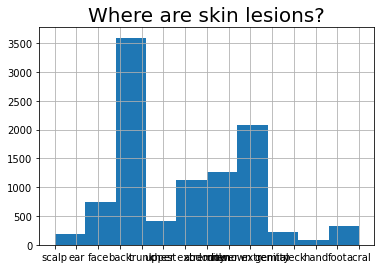

In [0]:
tile_df["localization"].hist()
plt.title("Where are skin lesions?", fontdict={"fontsize" : 20});


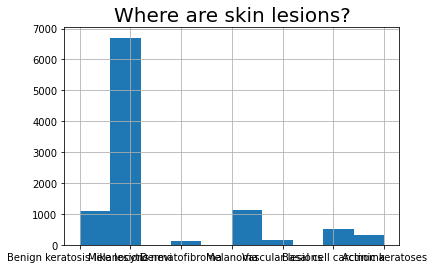

In [0]:
tile_df["cell_type"].hist()
plt.title("Where are skin lesions?", fontdict={"fontsize" : 20});

**Cleaning Data**

* Show if there is a null data

In [0]:
tile_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

* Fill the null values by their mean

In [0]:
print(tile_df['age'].mean())

51.863828077927295


In [0]:
tile_df['age'].fillna((tile_df['age'].mean()), inplace=True)

* Show if there is a null data

In [0]:
tile_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

**Loading and resize images**

* Resize the images to 100 * 75 which tensorflow can handle

In [0]:
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [0]:
# Checking the image size distribution
tile_df['image'].map(lambda x: x.shape)

0        (75, 100, 3)
1        (75, 100, 3)
2        (75, 100, 3)
3        (75, 100, 3)
4        (75, 100, 3)
             ...     
10010    (75, 100, 3)
10011    (75, 100, 3)
10012    (75, 100, 3)
10013    (75, 100, 3)
10014    (75, 100, 3)
Name: image, Length: 10015, dtype: object

* Show some image samples

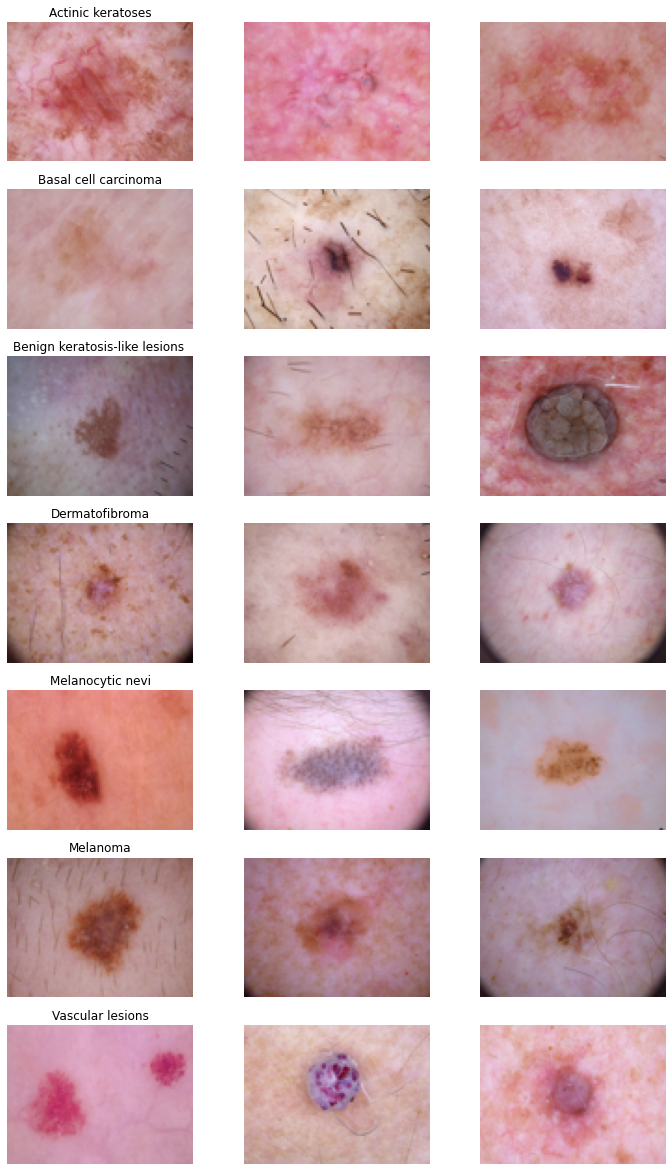

In [0]:
n_samples = 3
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

**Dataset Split**

* Splitting data into train and test with 80:20 ratio

In [0]:
features=tile_df.drop(columns=['cell_type_idx'],axis=1)
target=tile_df['cell_type_idx']

# 'train_test_split' splits arrays or matrices into random train and test subsets
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

**Normalization**

* Subtract their mean values from it and then dividing by their standard deviation

In [0]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

**Label Encoding**

* Labels are 7 different classes of cell types from 0 to 6. We need to encode these lables to one hot vectors

In [0]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

**Training and Validation Split**

* validate:train >> 10:90 %

In [0]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 2)

In [0]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

**Model Building**

In [0]:
#input_shape = (75, 100, 3)
#num_classes = 7
#model = Sequential([
 #   Conv2D(32, 3, padding='same', activation='relu', input_shape=input_shape),
  #  Conv2D(32, 3, padding='same', activation='relu'),
   # MaxPooling2D(),
    #Dropout(0.25),

    #Conv2D(64, 3, padding='same', activation='relu', input_shape=input_shape),
    #Conv2D(64, 3, padding='same', activation='relu'),
    #MaxPooling2D(),
    #Dropout(0.4),
    
    #Conv2D(128, 3, padding='same', activation='relu'),
    #MaxPooling2D(),
    #Dropout(0.5),
    
   # Flatten(),
   # Dense(128, activation='relu'),
    #Dropout(0.5),
    
    #Dense(7, activation='softmax')
#])

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam


# Our input feature map is 75x100x3: 75x100 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(75, 100, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu', padding='same')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and softmax activation
output = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model
model = Model(img_input, output)

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [0]:
#model.compile(optimizer='adam',
             # loss='binary_crossentropy',
             #metrics=['accuracy'])

In [0]:

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[accuracy])

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
def get_call_back():
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
  reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                          factor=0.5, 
                                           min_lr=0.00001)
  return[reduce_lr]

#reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                 #factor=0.2,
                                #patience=5,
                                 #  min_lr=0.001)


In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75, 100, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 75, 100, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 12, 64)         0     

**Data Augmentation**

* Avoiding the overfitting

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False
        )  # randomly flip images
datagen.fit(x_train)

**Fitting The model**

In [0]:
#epochs = 50 
epochs = 30 
batch_size = 160
history = model.fit(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    validation_steps=x_validate.shape[0] // batch_size
    ,callbacks=get_call_back()
)

Epoch 1/30
40/40 [==============================] - 10s 250ms/step - loss: 0.4774 - accuracy: 0.8155 - val_loss: 0.6018 - val_accuracy: 0.7792 - lr: 1.0000e-05
Epoch 2/30
40/40 [==============================] - 10s 253ms/step - loss: 0.4758 - accuracy: 0.8136 - val_loss: 0.6027 - val_accuracy: 0.7792 - lr: 1.0000e-05
Epoch 3/30
40/40 [==============================] - 10s 248ms/step - loss: 0.4736 - accuracy: 0.8200 - val_loss: 0.6023 - val_accuracy: 0.7804 - lr: 1.0000e-05
Epoch 4/30
40/40 [==============================] - 10s 246ms/step - loss: 0.4765 - accuracy: 0.8253 - val_loss: 0.6028 - val_accuracy: 0.7792 - lr: 1.0000e-05
Epoch 5/30
40/40 [==============================] - 10s 246ms/step - loss: 0.4893 - accuracy: 0.8133 - val_loss: 0.6028 - val_accuracy: 0.7792 - lr: 1.0000e-05
Epoch 6/30
40/40 [==============================] - 10s 248ms/step - loss: 0.4672 - accuracy: 0.8248 - val_loss: 0.6027 - val_accuracy: 0.7785 - lr: 1.0000e-05
Epoch 7/30
40/40 [======================

**Model Evaluation**

In [0]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

51/51 [==============================] - 0s 4ms/step - loss: 0.5882 - accuracy: 0.7785
Validation: accuracy = 0.778540  ;  loss_v = 0.588209
Test: accuracy = 0.765851  ;  loss = 0.613839


In [0]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


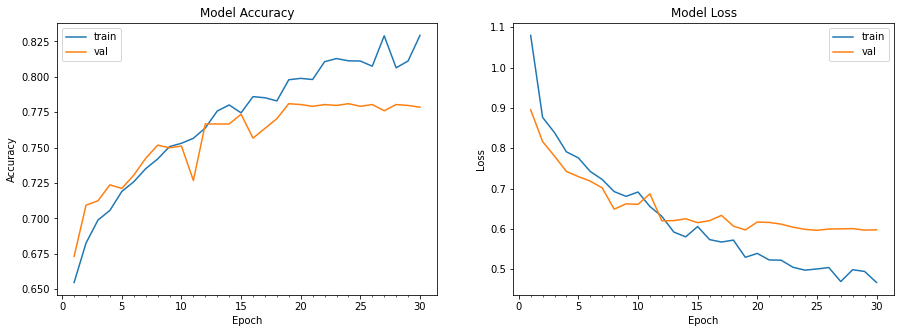

In [0]:
plot_model_history(history)